# **Data process**

## Đổi tên các cột concat()

In [1]:
import pandas as pd

anno_df = pd.read_csv('/kaggle/input/project2-cs114-data/wecode.data/annonimized.csv')

anno_df.rename(columns={
    "concat('it001',`assignment_id`)": 'a_id',
    "concat('it001',`problem_id`)": 'p_id',
    "concat('it001', username)": 'username',
    "concat('it001',`language_id`)": 'lang_id',
}, inplace=True)

anno_df.head()

,a_id,p_id,username,is_final,status,pre_score,coefficient,lang_id,created_at,updated_at,judgement
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."


## Xử lí judgement

In [2]:
import json

def safe_parse_judgement(j):
    try:
        data = json.loads(j)
        return pd.Series({
            'times': data.get('times', []),
            'mems': data.get('mems', []),
            'verdicts': data.get('verdicts', {})
        })
    except:
        return pd.Series({'times': [], 'mems': [], 'verdicts': {}})
        
# Giả sử df là DataFrame bạn đang dùng, với cột 'judgement' là chuỗi JSON
# Chuyển cột 'judgement' thành dict
anno_df[['times', 'mems', 'verdicts']] = anno_df['judgement'].apply(safe_parse_judgement)
anno_df.drop('judgement', axis=1, inplace=True)
anno_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295198 entries, 0 to 295197
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   a_id         295198 non-null  object
 1   p_id         295198 non-null  object
 2   username     295198 non-null  object
 3   is_final     295198 non-null  int64 
 4   status       295198 non-null  object
 5   pre_score    295198 non-null  int64 
 6   coefficient  295198 non-null  int64 
 7   lang_id      295198 non-null  object
 8   created_at   295198 non-null  object
 9   updated_at   295198 non-null  object
 10  times        295198 non-null  object
 11  mems         295198 non-null  object
 12  verdicts     295198 non-null  object
dtypes: int64(3), object(10)
memory usage: 29.3+ MB


# **Trích xuất đặc trưng sinh viên**

## Đếm số lượng assignment đã tham gia

In [3]:
num_assignments = (
    anno_df[['username', 'a_id']]
    .drop_duplicates()
    .groupby('username')
    .size()
    .reset_index(name='num_assignments')
)

num_assignments

,username,num_assignments
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,9
2,01122b3ef7e59b84189e65985305f575d6bdf83c,7
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,4
4,013de369c439ab0ead8aa7da64423aa395a8be39,8
...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,9
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,6
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,6
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,7


## Đếm số lượng cột Status là SCORE và Error

In [4]:
# Lọc những dòng có status là "Compilation Error"
filtered_df = anno_df[anno_df['status'] == 'SCORE']

# Đếm số lượng theo từng username
num_score = filtered_df.groupby('username').size().reset_index(name='score_count')

num_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   username     1475 non-null   object
 1   score_count  1475 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.2+ KB


In [5]:
# Lọc những dòng có status là "Compilation Error"
filtered_df = anno_df[(anno_df['status'] == 'Compilation Error') | (anno_df['status'] == 'Syntax Error')]

# Đếm số lượng theo từng username
num_error = filtered_df.groupby('username').size().reset_index(name='compilation_error_count')

num_error.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   username                 1428 non-null   object
 1   compilation_error_count  1428 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.4+ KB


## Số lần submit ứng với user

In [6]:
num_submit= anno_df['username'].value_counts()
num_submit_df = num_submit.reset_index()
num_submit_df.columns = ['username', 'num_submit']

num_submit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   username    1489 non-null   object
 1   num_submit  1489 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


## Số problem hoàn thành

In [7]:
# num_completed_problems = anno_df[anno_df['is_final'] == 1].groupby('username')['p_id'].nunique().reset_index(name='num_completed_problems')

# num_completed_problems

num_completed_problems = (
    anno_df[anno_df['pre_score'] == 10000]
    .drop_duplicates(subset=['username', 'p_id'])
    .groupby('username')
    .size()
    .reset_index(name='num_completed_problems')
)

num_completed_problems

,username,num_completed_problems
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,46
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,72
2,01122b3ef7e59b84189e65985305f575d6bdf83c,58
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,47
4,013de369c439ab0ead8aa7da64423aa395a8be39,44
...,...,...
1444,feb8a2859a011c59efd22ed419cb69288fe03627,34
1445,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,74
1446,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,99
1447,ff3fa2ec64294f37ae968159f810ebeda7966c51,30


## Số problem hoàn thành trễ

In [8]:
num_late_submit = (
    anno_df[(anno_df['coefficient'] < 100) & (anno_df['pre_score'] == 10000)]
    .drop_duplicates(subset=['username', 'p_id'])
    .groupby('username')
    .size()
    .reset_index(name='num_late_submit')
)

num_late_submit

,username,num_late_submit
0,0155f91fe242fe55e1af631b0f0afbe9938b185c,1
1,052039d5c5915699359b1d549b36ea69330c0ac3,1
2,05b134c1a682085880fb7ce76d221a48955e5b8a,2
3,0a9b6ec3e82e8a2527b21eb3420a6d9b72f4f71e,9
4,0aad9682c3c4280eb05dbd27e6cab55f4b1ae4b4,1
...,...,...
91,f7875ec1207504a229cd9b5ca132437c6bdd6a4d,2
92,f86b9fba1d59be7c864d4f23d0c7674113a27cab,2
93,f9491b0ab4aee90c428545e0e315a3af1f827595,2
94,f9f4d4ef2a3de006bd037db9eb160ab8e51c79f2,9


## Trung bình pre_score và coefficient

In [9]:
mean_scores = anno_df.groupby('username')[['pre_score', 'coefficient']].mean().reset_index()
mean_scores

,username,pre_score,coefficient
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5504.149660,100.000000
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,5488.552124,100.000000
2,01122b3ef7e59b84189e65985305f575d6bdf83c,5973.753846,100.000000
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,5952.760000,100.000000
4,013de369c439ab0ead8aa7da64423aa395a8be39,6474.448598,97.196262
...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,5581.081081,100.000000
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,6204.557692,100.000000
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,4998.466819,100.000000
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,4343.329787,100.000000


## Số bài khó hoàn thành

In [10]:
completed = (
    anno_df[anno_df['pre_score'] == 10000]
    .drop_duplicates(subset=['username', 'a_id', 'p_id'])
)

total_users_per_aid = (
    anno_df[['username', 'a_id']]
    .drop_duplicates()
    .groupby('a_id')
    .size()
    .reset_index(name='total_users')
)

num_completed_per_problem = (
    completed.groupby(['a_id', 'p_id'])['username']
    .nunique()
    .reset_index(name='num_users_completed')
)

completion_rate_df = num_completed_per_problem.merge(total_users_per_aid, on='a_id')
completion_rate_df['completion_rate'] = completion_rate_df['num_users_completed'] / completion_rate_df['total_users']

In [11]:
# def classify_difficulty(rate):
#     if rate >= 0.7:
#         return 'easy'
#     elif rate >= 0.4:
#         return 'medium'
#     elif rate >= 0.2:
#         return 'hard'
#     else:
#         return 'ex_hard'

def classify_difficulty(rate):
    if rate >= 0.8:
        return 'easy'
    if rate >= 0.5:
        return 'medium'
    else:
        return 'hard'

completion_rate_df['difficulty'] = completion_rate_df['completion_rate'].apply(classify_difficulty)

completed_with_difficulty = completed.merge(
    completion_rate_df[['a_id', 'p_id', 'difficulty']],
    on=['a_id', 'p_id'],
    how='left'
)

num_submit_dif = (
    completed_with_difficulty
    .groupby(['username', 'difficulty'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Đảm bảo đủ 3 cột
for col in ['easy', 'medium', 'hard']:
    if col not in num_submit_dif.columns:
        num_submit_dif[col] = 0

num_submit_dif

difficulty,username,easy,hard,medium
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,35,3,9
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,60,2,10
2,01122b3ef7e59b84189e65985305f575d6bdf83c,31,15,13
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,34,2,11
4,013de369c439ab0ead8aa7da64423aa395a8be39,45,2,11
...,...,...,...,...
1444,feb8a2859a011c59efd22ed419cb69288fe03627,30,1,3
1445,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,67,5,3
1446,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,102,0,0
1447,ff3fa2ec64294f37ae968159f810ebeda7966c51,26,1,3


## Số lần submit cho mỗi problem

In [12]:
submit_per_problem = pd.merge(num_submit_df, num_completed_problems, on='username', how='outer')

# Tính toán
submit_per_problem['submit_per_problem'] = submit_per_problem['num_submit'] / (submit_per_problem['num_completed_problems'])

submit_per_problem.drop(['num_submit', 'num_completed_problems'], axis=1, inplace=True)

print(submit_per_problem.isnull().sum())

submit_per_problem.fillna(0, inplace=True)

print(submit_per_problem.isnull().sum())

submit_per_problem

username               0
submit_per_problem    40
dtype: int64
username              0
submit_per_problem    0
dtype: int64


,username,submit_per_problem
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,3.195652
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,3.597222
2,01122b3ef7e59b84189e65985305f575d6bdf83c,3.362069
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,2.127660
4,013de369c439ab0ead8aa7da64423aa395a8be39,2.431818
...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,2.176471
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,3.513514
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,4.414141
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,3.133333


## Thời gian trung bình làm 1 problem 

In [13]:
# Đây là sample chứng tỏ đây là năm nhuận với 2-29 nên sẽ thêm 2024 vào các sample thiếu năm

anno_df.iloc[182684]

a_id                    1bec7c0b6a9bd8f556a8554c5012dcb778460bac
p_id                    f6332fbfbd01c31062bfe102deec29525aabec5a
username                0f0664021ebbec70b1d3bb5a5419e22507179671
is_final                                                       0
status                                                     SCORE
pre_score                                                      0
coefficient                                                  100
lang_id                                                   it0012
created_at                                        02-29 01:25:00
updated_at                                        02-29 01:26:38
times          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
mems           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
verdicts                                           {'WRONG': 20}
Name: 182684, dtype: object

In [14]:
# Thêm vào cột time_diff

import re 

LEAP_YEAR = "2024"  # Năm nhuận gần nhất

created_raw = anno_df['created_at'].copy()
updated_raw = anno_df['updated_at'].copy()

def ensure_year(date_str):
    if pd.isna(date_str):
        return date_str
    # Nếu đã có năm → giữ nguyên
    if re.search(r'\b\d{4}\b', date_str):
        return date_str
    # Nếu không có năm → thêm năm nhuận
    return f"{LEAP_YEAR} {date_str}"

# Áp dụng hàm mới
anno_df['created_at'] = created_raw.apply(ensure_year)
anno_df['updated_at'] = updated_raw.apply(ensure_year)

# Chuyển về datetime
anno_df['created_at'] = pd.to_datetime(anno_df['created_at'], errors='coerce')
anno_df['updated_at'] = pd.to_datetime(anno_df['updated_at'], errors='coerce')

# Tính time_diff (đơn vị giây)
anno_df['time_diff'] = (anno_df['updated_at'] - anno_df['created_at']).dt.total_seconds()

# Chỉ giữ time_diff nếu is_final == 1
anno_df['time_diff'] = anno_df['time_diff'].where(anno_df['is_final'] == 1)

In [15]:
# Bước 1: Nhóm theo username và p_id, rồi tính thời gian trung bình mỗi cặp
user_p_mean = (
    anno_df
    .groupby(['username', 'p_id'])['time_diff']
    .mean()
    .reset_index(name='avg_time_per_problem')
)

# Bước 2: Tính trung bình toàn bộ các p_id của từng user
user_mean_time = (
    user_p_mean
    .groupby('username')['avg_time_per_problem']
    .mean()
    .reset_index(name='avg_time_per_user')
)

user_mean_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   username           1489 non-null   object 
 1   avg_time_per_user  1488 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


## Merge các đặc trưng đã trích xuất

In [16]:
summary_df = num_submit_df \
    .merge(num_completed_problems, on='username', how='left') \
    .merge(num_late_submit, on='username', how='left') \
    .merge(mean_scores, on='username', how='left') \
    .merge(num_submit_dif, on='username', how='left') \
    .merge(submit_per_problem, on='username', how='left') \
    .merge(user_mean_time, on='username', how='left') \
    .merge(num_score, on='username', how='left') \
    .merge(num_error, on='username', how='left') \
    .merge(num_assignments, on='username', how='left') 

summary_df = summary_df.fillna(0)

summary_df[['num_submit', 'num_completed_problems', 'num_late_submit', 'easy', 'medium', 'hard', 'score_count', 'compilation_error_count']] = summary_df[[
    'num_submit', 'num_completed_problems', 'num_late_submit', 'easy', 'medium', 'hard', 'score_count','compilation_error_count']].astype(int)

summary_df

,username,num_submit,num_completed_problems,num_late_submit,pre_score,coefficient,easy,hard,medium,submit_per_problem,avg_time_per_user,score_count,compilation_error_count,num_assignments
0,9f605b4802c811805adc38ae19035ded09a5e4b5,1047,86,0,3071.882521,100.0,66,8,12,12.174419,854.175258,717,330,7
1,2cd5132c3c49bd9d4d5081e386a4d69a593f850a,1022,100,0,4413.339530,100.0,67,10,25,10.220000,9.958333,787,235,16
2,58f61331a385caeed17baaf54abea308426d50fe,833,109,0,2771.621849,100.0,103,0,6,7.642202,134.963303,525,307,5
3,1abf62f1e76bc5ac164061cff2a8171d6b6de657,749,100,0,2747.838451,100.0,97,4,8,7.490000,892.610632,415,334,7
4,33b16210a7736a6f75ef1b1f3cb7070a4d29395e,745,88,0,3870.371812,100.0,74,6,11,8.465909,707.314286,546,199,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,503affec12fb99997f583ed73b60262572694795,1,1,0,10000.000000,100.0,0,1,0,1.000000,9.000000,1,0,1
1485,f2418c1ba0f63cb975e6d8c26ce4a145b11ad924,1,0,0,0.000000,100.0,0,0,0,0.000000,3.000000,1,0,1
1486,713487f0de26590bca3c759e2fef02b3a5bad9fd,1,1,0,10000.000000,100.0,0,1,0,1.000000,8.000000,1,0,1
1487,c4f595ca17b4c13287b0beec0dbd45d0e356055b,1,0,0,0.000000,100.0,0,0,0,0.000000,1.000000,0,1,1


# **Data cuối kì**

## Xử lí data cuối kì

In [17]:
ck_df = pd.read_csv('/kaggle/input/project2-cs114-data/wecode.data/ck-public.csv')
ck_df.dropna(inplace=True)
ck_df.rename(columns={'hash' : 'username'}, inplace=True)
ck_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 755 entries, 0 to 760
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   username  755 non-null    object 
 1   CK        755 non-null    float64
dtypes: float64(1), object(1)
memory usage: 17.7+ KB


## Merge với dataframe feature

(Note : Cảm giác mean_prescore và coefficient không có tác dụng)

In [18]:
ck_df = summary_df.merge(ck_df, on='username', how='inner')

ck_df.isnull().sum()

username                   0
num_submit                 0
num_completed_problems     0
num_late_submit            0
pre_score                  0
coefficient                0
easy                       0
hard                       0
medium                     0
submit_per_problem         0
avg_time_per_user          0
score_count                0
compilation_error_count    0
num_assignments            0
CK                         0
dtype: int64

In [19]:
print(ck_df['CK'].value_counts())

print(ck_df['CK'].astype(str).unique())

CK
6.0     83
5.0     70
4.5     62
6.5     62
7.5     61
7.0     55
5.5     54
8.0     51
4.0     43
3.5     36
8.5     29
2.5     28
3.0     26
2.0     21
1.0     15
9.0     14
0.0     13
10.0     9
1.5      9
9.5      8
0.5      6
Name: count, dtype: int64
['3.5' '4.5' '0.5' '6.0' '9.0' '7.0' '7.5' '8.5' '2.5' '5.5' '9.5' '8.0'
 '5.0' '2.0' '4.0' '6.5' '10.0' '3.0' '1.0' '1.5' '0.0']


## Chọn feature (Feature selection : Pearson Coefficient)

In [20]:
# Chọn các cột số liên quan (trừ 'username')
numeric_cols = ck_df.select_dtypes(include='number').columns

# Tính hệ số Pearson giữa tất cả các feature và cột TH
correlations = ck_df[numeric_cols].corr(method='pearson')

# Lấy chỉ cột liên quan đến TH
ck_corr = correlations['CK'].drop('CK')  # bỏ chính nó

In [21]:
ck_corr_sorted = ck_corr.sort_values(ascending=False)
print(ck_corr_sorted)

hard                       0.215202
medium                     0.157467
num_assignments            0.155241
pre_score                  0.150083
score_count                0.148687
avg_time_per_user          0.117758
num_late_submit            0.107545
num_submit                 0.083515
num_completed_problems     0.041248
easy                      -0.022140
submit_per_problem        -0.058326
coefficient               -0.100704
compilation_error_count   -0.113141
Name: CK, dtype: float64


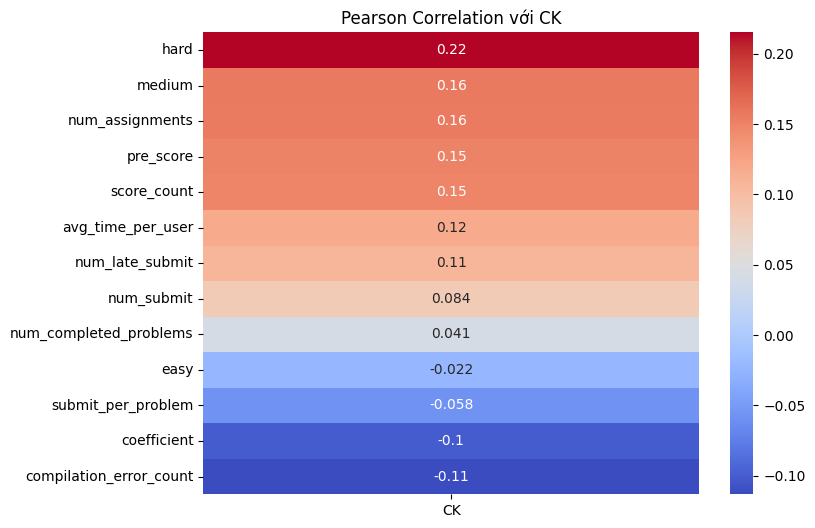

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(ck_corr_sorted.to_frame(), annot=True, cmap='coolwarm')
plt.title('Pearson Correlation với CK')
plt.show()

In [23]:
chosen_features = ck_corr[ck_corr > 0.05].index.to_list()
chosen_features

['num_submit',
 'num_late_submit',
 'pre_score',
 'hard',
 'medium',
 'avg_time_per_user',
 'score_count',
 'num_assignments']

# **Modeling**

## Chuẩn bị dữ liệu train, test

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Các cột đặc trưng
features = chosen_features
target = 'CK'

# Tách dữ liệu train-test
X = ck_df[features]
y = ck_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## SVR

In [25]:
from sklearn.svm import SVR

# Tạo pipeline chuẩn hóa dữ liệu và mô hình SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Các tham số cần dò (phần 'svr__' là để trỏ đến SVR bên trong pipeline)
param_grid = {
    'svr__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svr__C': [0.1, 1, 10, 100, 1000],
    'svr__gamma': ['scale', 'auto'],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5, 1.0]
}

# Tạo GridSearchCV
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Fit dữ liệu
grid_search.fit(X_train, y_train)

# In ra kết quả tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best R² score (validation):", grid_search.best_score_)

# Đánh giá trên tập test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R² score:", r2_score(y_test, y_pred))


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters: {'svr__C': 10, 'svr__epsilon': 1.0, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
Best R² score (validation): 0.12324517111873742
Test RMSE: 1.977083571648812
Test R² score: 0.1134220883423932


In [26]:
# Dự đoán
summary_features = summary_df[features]

summary_df['predicted_TH'] = best_model.predict(summary_features)

# In vài dòng kết quả
print(summary_df[['username', 'predicted_TH']].head())

# Xuất ra file .txt theo định dạng yêu cầu
summary_df[['username', 'predicted_TH']].to_csv(
    'svr_predict.txt', index=False, header=False
)

summary_df.drop('predicted_TH', axis=1)

                                   username  predicted_TH
0  9f605b4802c811805adc38ae19035ded09a5e4b5      3.278481
1  2cd5132c3c49bd9d4d5081e386a4d69a593f850a      6.375415
2  58f61331a385caeed17baaf54abea308426d50fe      1.811245
3  1abf62f1e76bc5ac164061cff2a8171d6b6de657      0.461451
4  33b16210a7736a6f75ef1b1f3cb7070a4d29395e      4.999949


,username,num_submit,num_completed_problems,num_late_submit,pre_score,coefficient,easy,hard,medium,submit_per_problem,avg_time_per_user,score_count,compilation_error_count,num_assignments
0,9f605b4802c811805adc38ae19035ded09a5e4b5,1047,86,0,3071.882521,100.0,66,8,12,12.174419,854.175258,717,330,7
1,2cd5132c3c49bd9d4d5081e386a4d69a593f850a,1022,100,0,4413.339530,100.0,67,10,25,10.220000,9.958333,787,235,16
2,58f61331a385caeed17baaf54abea308426d50fe,833,109,0,2771.621849,100.0,103,0,6,7.642202,134.963303,525,307,5
3,1abf62f1e76bc5ac164061cff2a8171d6b6de657,749,100,0,2747.838451,100.0,97,4,8,7.490000,892.610632,415,334,7
4,33b16210a7736a6f75ef1b1f3cb7070a4d29395e,745,88,0,3870.371812,100.0,74,6,11,8.465909,707.314286,546,199,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,503affec12fb99997f583ed73b60262572694795,1,1,0,10000.000000,100.0,0,1,0,1.000000,9.000000,1,0,1
1485,f2418c1ba0f63cb975e6d8c26ce4a145b11ad924,1,0,0,0.000000,100.0,0,0,0,0.000000,3.000000,1,0,1
1486,713487f0de26590bca3c759e2fef02b3a5bad9fd,1,1,0,10000.000000,100.0,0,1,0,1.000000,8.000000,1,0,1
1487,c4f595ca17b4c13287b0beec0dbd45d0e356055b,1,0,0,0.000000,100.0,0,0,0,0.000000,1.000000,0,1,1


## Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression

# Pipeline: chuẩn hóa dữ liệu + mô hình
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Tham số cần dò
param_grid = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]  # Chỉ hỗ trợ từ sklearn 1.0 trở lên
}

# Tạo GridSearchCV
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Fit dữ liệu
grid_search.fit(X_train, y_train)

# In ra kết quả tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best R² score (validation):", grid_search.best_score_)

# Đánh giá trên tập test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R² score:", r2_score(y_test, y_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'model__fit_intercept': True, 'model__positive': False}
Best R² score (validation): 0.1253380554566746
Test RMSE: 1.9775158144619593
Test R² score: 0.11303438715789249


In [28]:
# Dự đoán
summary_features = summary_df[features]

summary_df['predicted_TH'] = best_model.predict(summary_features)

# In vài dòng kết quả
print(summary_df[['username', 'predicted_TH']].head())

# Xuất ra file .txt theo định dạng yêu cầu
summary_df[['username', 'predicted_TH']].to_csv(
    'linearregression_predict.txt', index=False, header=False
)

summary_df.drop('predicted_TH', axis=1)

                                   username  predicted_TH
0  9f605b4802c811805adc38ae19035ded09a5e4b5      3.351898
1  2cd5132c3c49bd9d4d5081e386a4d69a593f850a      6.559029
2  58f61331a385caeed17baaf54abea308426d50fe      1.804125
3  1abf62f1e76bc5ac164061cff2a8171d6b6de657      0.449704
4  33b16210a7736a6f75ef1b1f3cb7070a4d29395e      5.085637


,username,num_submit,num_completed_problems,num_late_submit,pre_score,coefficient,easy,hard,medium,submit_per_problem,avg_time_per_user,score_count,compilation_error_count,num_assignments
0,9f605b4802c811805adc38ae19035ded09a5e4b5,1047,86,0,3071.882521,100.0,66,8,12,12.174419,854.175258,717,330,7
1,2cd5132c3c49bd9d4d5081e386a4d69a593f850a,1022,100,0,4413.339530,100.0,67,10,25,10.220000,9.958333,787,235,16
2,58f61331a385caeed17baaf54abea308426d50fe,833,109,0,2771.621849,100.0,103,0,6,7.642202,134.963303,525,307,5
3,1abf62f1e76bc5ac164061cff2a8171d6b6de657,749,100,0,2747.838451,100.0,97,4,8,7.490000,892.610632,415,334,7
4,33b16210a7736a6f75ef1b1f3cb7070a4d29395e,745,88,0,3870.371812,100.0,74,6,11,8.465909,707.314286,546,199,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,503affec12fb99997f583ed73b60262572694795,1,1,0,10000.000000,100.0,0,1,0,1.000000,9.000000,1,0,1
1485,f2418c1ba0f63cb975e6d8c26ce4a145b11ad924,1,0,0,0.000000,100.0,0,0,0,0.000000,3.000000,1,0,1
1486,713487f0de26590bca3c759e2fef02b3a5bad9fd,1,1,0,10000.000000,100.0,0,1,0,1.000000,8.000000,1,0,1
1487,c4f595ca17b4c13287b0beec0dbd45d0e356055b,1,0,0,0.000000,100.0,0,0,0,0.000000,1.000000,0,1,1


## Ridge Regression

In [29]:
from sklearn.linear_model import Ridge

# Pipeline: chuẩn hóa + mô hình Ridge
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

# Grid các tham số cho Ridge
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100],               # hệ số điều chuẩn
    'model__fit_intercept': [True, False],
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']
}

# Tạo GridSearchCV
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Fit dữ liệu
grid_search.fit(X_train, y_train)

# In ra kết quả tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best R² score (validation):", grid_search.best_score_)

# Đánh giá trên tập test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R² score:", r2_score(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'model__alpha': 0.1, 'model__fit_intercept': True, 'model__solver': 'auto'}
Best R² score (validation): 0.12536655583834427
Test RMSE: 1.9771200466787846
Test R² score: 0.11338937525462645


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py", line 129, in _solve_sparse_cg
    coefs[i], info = sp_linalg.cg(
                     ^^^^^^^^^^^^^
TypeError: cg() got an unexpected keyword argument 'tol'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_tr

In [30]:
# Dự đoán
summary_features = summary_df[features]

summary_df['predicted_TH'] = best_model.predict(summary_features)

# In vài dòng kết quả
print(summary_df[['username', 'predicted_TH']].head())

# Xuất ra file .txt theo định dạng yêu cầu
summary_df[['username', 'predicted_TH']].to_csv(
    'ridgeregression_predict.txt', index=False, header=False
)

summary_df.drop('predicted_TH', axis=1)

                                   username  predicted_TH
0  9f605b4802c811805adc38ae19035ded09a5e4b5      3.387476
1  2cd5132c3c49bd9d4d5081e386a4d69a593f850a      6.561505
2  58f61331a385caeed17baaf54abea308426d50fe      1.848944
3  1abf62f1e76bc5ac164061cff2a8171d6b6de657      0.516886
4  33b16210a7736a6f75ef1b1f3cb7070a4d29395e      5.096649


,username,num_submit,num_completed_problems,num_late_submit,pre_score,coefficient,easy,hard,medium,submit_per_problem,avg_time_per_user,score_count,compilation_error_count,num_assignments
0,9f605b4802c811805adc38ae19035ded09a5e4b5,1047,86,0,3071.882521,100.0,66,8,12,12.174419,854.175258,717,330,7
1,2cd5132c3c49bd9d4d5081e386a4d69a593f850a,1022,100,0,4413.339530,100.0,67,10,25,10.220000,9.958333,787,235,16
2,58f61331a385caeed17baaf54abea308426d50fe,833,109,0,2771.621849,100.0,103,0,6,7.642202,134.963303,525,307,5
3,1abf62f1e76bc5ac164061cff2a8171d6b6de657,749,100,0,2747.838451,100.0,97,4,8,7.490000,892.610632,415,334,7
4,33b16210a7736a6f75ef1b1f3cb7070a4d29395e,745,88,0,3870.371812,100.0,74,6,11,8.465909,707.314286,546,199,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,503affec12fb99997f583ed73b60262572694795,1,1,0,10000.000000,100.0,0,1,0,1.000000,9.000000,1,0,1
1485,f2418c1ba0f63cb975e6d8c26ce4a145b11ad924,1,0,0,0.000000,100.0,0,0,0,0.000000,3.000000,1,0,1
1486,713487f0de26590bca3c759e2fef02b3a5bad9fd,1,1,0,10000.000000,100.0,0,1,0,1.000000,8.000000,1,0,1
1487,c4f595ca17b4c13287b0beec0dbd45d0e356055b,1,0,0,0.000000,100.0,0,0,0,0.000000,1.000000,0,1,1


## CatBoost

In [31]:
from catboost import CatBoostRegressor

# Định nghĩa mô hình cơ bản
model = CatBoostRegressor(verbose=0, random_state=42)

# Các tham số cần dò
# param_grid = {
#     'iterations': [50, 100, 300, 500],
#     'depth': [4, 6, 8, 10, 12],
#     'learning_rate': [0.001, 0.01, 0.05, 0.1],
#     'l2_leaf_reg': [1, 3, 5, 7, 9]
# }

param_grid = {
    'iterations': [100, 300, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
}


# Tạo GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='r2', cv=5, n_jobs=-1, verbose=1)

# Fit dữ liệu
grid_search.fit(X_train, y_train)

# In ra kết quả tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best R² score (validation):", grid_search.best_score_)

# Đánh giá trên tập test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R² score:", r2_score(y_test, y_pred))

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best parameters: {'bootstrap_type': 'Bernoulli', 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best R² score (validation): 0.19092438364287473
Test RMSE: 1.8873668272333741
Test R² score: 0.1920592981271414


In [32]:
# Dự đoán
summary_features = summary_df[features]

summary_df['predicted_TH'] = best_model.predict(summary_features)

# In vài dòng kết quả
print(summary_df[['username', 'predicted_TH']].head())

# Xuất ra file .txt theo định dạng yêu cầu
summary_df[['username', 'predicted_TH']].to_csv(
    'catboost_predict.txt', index=False, header=False
)

summary_df.drop('predicted_TH', axis=1)

                                   username  predicted_TH
0  9f605b4802c811805adc38ae19035ded09a5e4b5      5.576733
1  2cd5132c3c49bd9d4d5081e386a4d69a593f850a      6.080827
2  58f61331a385caeed17baaf54abea308426d50fe      4.749120
3  1abf62f1e76bc5ac164061cff2a8171d6b6de657      5.326769
4  33b16210a7736a6f75ef1b1f3cb7070a4d29395e      5.730644


,username,num_submit,num_completed_problems,num_late_submit,pre_score,coefficient,easy,hard,medium,submit_per_problem,avg_time_per_user,score_count,compilation_error_count,num_assignments
0,9f605b4802c811805adc38ae19035ded09a5e4b5,1047,86,0,3071.882521,100.0,66,8,12,12.174419,854.175258,717,330,7
1,2cd5132c3c49bd9d4d5081e386a4d69a593f850a,1022,100,0,4413.339530,100.0,67,10,25,10.220000,9.958333,787,235,16
2,58f61331a385caeed17baaf54abea308426d50fe,833,109,0,2771.621849,100.0,103,0,6,7.642202,134.963303,525,307,5
3,1abf62f1e76bc5ac164061cff2a8171d6b6de657,749,100,0,2747.838451,100.0,97,4,8,7.490000,892.610632,415,334,7
4,33b16210a7736a6f75ef1b1f3cb7070a4d29395e,745,88,0,3870.371812,100.0,74,6,11,8.465909,707.314286,546,199,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,503affec12fb99997f583ed73b60262572694795,1,1,0,10000.000000,100.0,0,1,0,1.000000,9.000000,1,0,1
1485,f2418c1ba0f63cb975e6d8c26ce4a145b11ad924,1,0,0,0.000000,100.0,0,0,0,0.000000,3.000000,1,0,1
1486,713487f0de26590bca3c759e2fef02b3a5bad9fd,1,1,0,10000.000000,100.0,0,1,0,1.000000,8.000000,1,0,1
1487,c4f595ca17b4c13287b0beec0dbd45d0e356055b,1,0,0,0.000000,100.0,0,0,0,0.000000,1.000000,0,1,1


## Cheat

In [33]:
# # Giả sử: th_df có cột 'username' và 'TH'
# #         summary_df có cột 'username' và 'predicted_TH'

# # Gộp 2 DataFrame theo 'username', ưu tiên lấy giá trị TH nếu có
# merged = summary_df.merge(th_df[['username', 'TH']], on='username', how='left')

# # Nếu có TH thật thì dùng, không thì dùng predicted_TH
# merged['final_TH'] = merged['TH'].fillna(merged['predicted_TH'])

# # Ghi ra file .txt
# merged[['username', 'final_TH']].to_csv('predictions_with_groundtruth.txt', index=False, header=False)

## XGBoost

In [34]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Khởi tạo mô hình cơ bản
model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=0  # Tắt log của XGBoost
)

# Grid các tham số cần dò
# param_grid = {
#     'n_estimators': [20, 50, 100, 200, 300],
#     'max_depth': [1, 3, 5, 7, 9],
#     'learning_rate': [0.001, 0.01, 0.05, 0.1],
#     'subsample': [0.4, 0.6, 0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

param_grid = {
    'n_estimators': [50, 100, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 3, 5]    # L2 regularization
}


# Khởi tạo GridSearchCV
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Huấn luyện
grid_search.fit(X_train, y_train)

# Kết quả tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation R²:", grid_search.best_score_)

# Đánh giá trên tập test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse}")
print(f"Test R² score: {r2}")


Fitting 5 folds for each of 11664 candidates, totalling 58320 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 5, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best cross-validation R²: 0.206810589049328
Test RMSE: 1.890604462321629
Test R² score: 0.18928499824423695


In [35]:
# Dự đoán
summary_features = summary_df[features]

summary_df['predicted_TH'] = best_model.predict(summary_features)

# In vài dòng kết quả
print(summary_df[['username', 'predicted_TH']].head())

# Xuất ra file .txt theo định dạng yêu cầu
summary_df[['username', 'predicted_TH']].to_csv(
    'xgboost_predict.txt', index=False, header=False
)

summary_df.drop('predicted_TH', axis=1)

                                   username  predicted_TH
0  9f605b4802c811805adc38ae19035ded09a5e4b5      6.465565
1  2cd5132c3c49bd9d4d5081e386a4d69a593f850a      5.529878
2  58f61331a385caeed17baaf54abea308426d50fe      4.693596
3  1abf62f1e76bc5ac164061cff2a8171d6b6de657      6.160470
4  33b16210a7736a6f75ef1b1f3cb7070a4d29395e      6.408420


,username,num_submit,num_completed_problems,num_late_submit,pre_score,coefficient,easy,hard,medium,submit_per_problem,avg_time_per_user,score_count,compilation_error_count,num_assignments
0,9f605b4802c811805adc38ae19035ded09a5e4b5,1047,86,0,3071.882521,100.0,66,8,12,12.174419,854.175258,717,330,7
1,2cd5132c3c49bd9d4d5081e386a4d69a593f850a,1022,100,0,4413.339530,100.0,67,10,25,10.220000,9.958333,787,235,16
2,58f61331a385caeed17baaf54abea308426d50fe,833,109,0,2771.621849,100.0,103,0,6,7.642202,134.963303,525,307,5
3,1abf62f1e76bc5ac164061cff2a8171d6b6de657,749,100,0,2747.838451,100.0,97,4,8,7.490000,892.610632,415,334,7
4,33b16210a7736a6f75ef1b1f3cb7070a4d29395e,745,88,0,3870.371812,100.0,74,6,11,8.465909,707.314286,546,199,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,503affec12fb99997f583ed73b60262572694795,1,1,0,10000.000000,100.0,0,1,0,1.000000,9.000000,1,0,1
1485,f2418c1ba0f63cb975e6d8c26ce4a145b11ad924,1,0,0,0.000000,100.0,0,0,0,0.000000,3.000000,1,0,1
1486,713487f0de26590bca3c759e2fef02b3a5bad9fd,1,1,0,10000.000000,100.0,0,1,0,1.000000,8.000000,1,0,1
1487,c4f595ca17b4c13287b0beec0dbd45d0e356055b,1,0,0,0.000000,100.0,0,0,0,0.000000,1.000000,0,1,1
